In [204]:
#!pip install quandl
from cryptocmd import CmcScraper
from datetime import date
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import quandl
import shap


import scipy.stats as stats # For statistical inference
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error as metric
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale

from pmdarima import auto_arima

# Import & Generate Data

### Bitcoin 

In [2]:

#Día actual
today = date.today()

today= today.strftime('%d-%m-%Y')
today = str(today)
print(today)


17-07-2021


In [3]:

# initialise scraper without time interval
scraper = CmcScraper("BTC", '01-01-2017', today )

# get raw data as list of list
headers, data1 = scraper.get_data()

# get data in a json format
xrp_json_data = scraper.get_data("json")

# Pandas dataFrame for the same data
data = scraper.get_dataframe()

print(data.shape)
data.head()


(1658, 7)


,Date,Open,High,Low,Close,Volume,Market Cap
0,2021-07-16,31841.551324,32218.406612,31100.673372,31421.538454,2.369948e+10,5.894158e+11
1,2021-07-15,32827.874549,33159.640948,31175.709747,31780.731374,2.130052e+10,5.961245e+11
2,2021-07-14,32723.846052,33061.398956,31639.124106,32822.348737,2.137653e+10,6.156350e+11
3,2021-07-13,33125.468694,33327.101417,32261.420484,32702.025924,1.912086e+10,6.133437e+11
4,2021-07-12,34254.016595,34592.155604,32697.308651,33155.848131,2.432150e+10,6.218280e+11


In [4]:
def data_futuro(dataset, columna,n_dias):
    df = pd.DataFrame
    df = dataset
    df[columna] = dataset[columna].shift(n_dias)
    df = df[n_dias:]
    return df

In [5]:
data = data_futuro(data, 'Close', 1)

In [6]:
data.head()

,Date,Open,High,Low,Close,Volume,Market Cap
1,2021-07-15,32827.874549,33159.640948,31175.709747,31421.538454,2.130052e+10,5.961245e+11
2,2021-07-14,32723.846052,33061.398956,31639.124106,31780.731374,2.137653e+10,6.156350e+11
3,2021-07-13,33125.468694,33327.101417,32261.420484,32822.348737,1.912086e+10,6.133437e+11
4,2021-07-12,34254.016595,34592.155604,32697.308651,32702.025924,2.432150e+10,6.218280e+11
5,2021-07-11,33509.077262,34584.704550,33346.737722,33155.848131,2.010873e+10,6.421381e+11


In [7]:
def MACD(data):
    data = data.sort_values(by = 'Date')
    exp1 = data.Close.ewm(span=12, adjust=False).mean()
    exp2 = data.Close.ewm(span=26, adjust=False).mean()
    macd = exp1-exp2
    exp3 = macd.ewm(span=9, adjust=False).mean()

    plt.figure(figsize=[10,10])
    plt.plot(data.Date, macd, label='AMD MACD', color = '#EBD2BE')
    plt.plot(data.Date, exp3, label='Signal Line', color='#E5A4CB')
    plt.legend(loc='upper left')
    plt.show()
    
    return macd, exp3

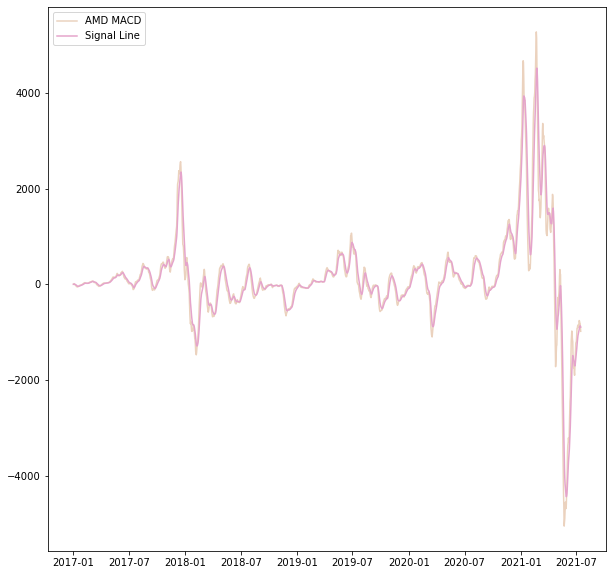

In [8]:
data['macd'], data['signal'] = MACD(data)

In [9]:
def rolmean_std(data, periods):
    data = data.sort_values(by = 'Date')
    rolmean = pd.Series(data['Close']).rolling(window=periods).mean()
    rolstd = pd.Series(data['Close']).rolling(window=periods).std()

    plt.plot(data.Date, data['Close'].values)
    plt.plot(data.Date, rolmean, color='orange', label='Mean')
    plt.plot(data.Date, rolstd, color='lime', label = 'Std')
    plt.legend(loc='best')
    plt.title('Mean & Standard Deviation')
    plt.show(block=False)
    return rolmean, rolstd

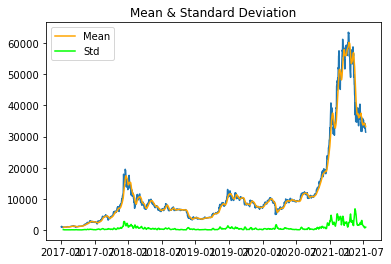

In [10]:
data['mediamovil12'], data['sdmovil12'] = rolmean_std(data, 12)

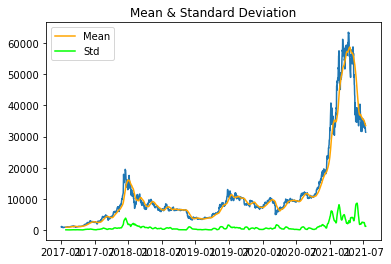

In [11]:
data['mediamovil26'], data['sdmovil26'] = rolmean_std(data, 26)

In [12]:
def bollinger(data, periods):
    data = data.sort_values(by = 'Date')
    rolmean = pd.Series(data['Close']).rolling(window=periods).mean()
    rolstd = pd.Series(data['Close']).rolling(window=periods).std()
    
    bollup = rolmean + rolstd*2
    bolldw = rolmean - rolstd*2

    plt.plot(data.Date, data['Close'].values)
    plt.plot(data.Date, bollup , color='orange', label='Mean')
    plt.plot(data.Date, bolldw, color='lime', label = 'Std')
    plt.legend(loc='best')
    plt.title('Mean & Standard Deviation')
    plt.show(block=False)
    return bollup, bolldw

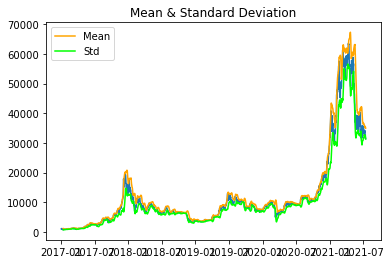

In [13]:
data['bollup12'] , data['bolldw12'] = bollinger(data,12)

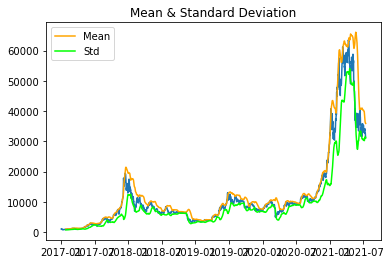

In [14]:
data['bollup26'] , data['bolldw26'] = bollinger(data,26)

In [15]:
data.head()

,Date,Open,High,Low,Close,Volume,Market Cap,macd,signal,mediamovil12,sdmovil12,mediamovil26,sdmovil26,bollup12,bolldw12,bollup26,bolldw26
1,2021-07-15,32827.874549,33159.640948,31175.709747,31421.538454,2.130052e+10,5.961245e+11,-982.601774,-895.690554,33179.592101,905.057675,33537.118103,1200.235802,34989.707451,31369.476752,35937.589707,31136.646498
2,2021-07-14,32723.846052,33061.398956,31639.124106,31780.731374,2.137653e+10,6.156350e+11,-900.039715,-873.962749,33501.778877,910.468117,33701.608794,1191.732809,35322.715112,31680.842642,36085.074413,31318.143176
3,2021-07-13,33125.468694,33327.101417,32261.420484,32822.348737,1.912086e+10,6.133437e+11,-818.141389,-867.443508,33742.430296,787.566071,33849.114098,1181.771503,35317.562437,32167.298155,36212.657105,31485.571091
4,2021-07-12,34254.016595,34592.155604,32697.308651,32702.025924,2.432150e+10,6.218280e+11,-807.764690,-879.769037,33831.988617,732.614986,33963.148561,1221.124077,35297.218590,32366.758645,36405.396715,31520.900408
5,2021-07-11,33509.077262,34584.704550,33346.737722,33155.848131,2.010873e+10,6.421381e+11,-770.519895,-897.770124,33904.496261,648.887217,34168.974648,1432.727541,35202.270695,32606.721827,37034.429730,31303.519566


In [16]:
data = data.set_index(data['Date'], drop=False, append=False, inplace=False, verify_integrity=False).drop('Date', 1)
data.head()

,Open,High,Low,Close,Volume,Market Cap,macd,signal,mediamovil12,sdmovil12,mediamovil26,sdmovil26,bollup12,bolldw12,bollup26,bolldw26
Date,,,,,,,,,,,,,,,,
2021-07-15,32827.874549,33159.640948,31175.709747,31421.538454,2.130052e+10,5.961245e+11,-982.601774,-895.690554,33179.592101,905.057675,33537.118103,1200.235802,34989.707451,31369.476752,35937.589707,31136.646498
2021-07-14,32723.846052,33061.398956,31639.124106,31780.731374,2.137653e+10,6.156350e+11,-900.039715,-873.962749,33501.778877,910.468117,33701.608794,1191.732809,35322.715112,31680.842642,36085.074413,31318.143176
2021-07-13,33125.468694,33327.101417,32261.420484,32822.348737,1.912086e+10,6.133437e+11,-818.141389,-867.443508,33742.430296,787.566071,33849.114098,1181.771503,35317.562437,32167.298155,36212.657105,31485.571091
2021-07-12,34254.016595,34592.155604,32697.308651,32702.025924,2.432150e+10,6.218280e+11,-807.764690,-879.769037,33831.988617,732.614986,33963.148561,1221.124077,35297.218590,32366.758645,36405.396715,31520.900408
2021-07-11,33509.077262,34584.704550,33346.737722,33155.848131,2.010873e+10,6.421381e+11,-770.519895,-897.770124,33904.496261,648.887217,34168.974648,1432.727541,35202.270695,32606.721827,37034.429730,31303.519566


In [17]:
def var_porcentual(data, col):
    data = data.sort_values(by = 'Date')
    var = data[col].pct_change()[1:]
    return var

In [18]:
data['btc_return'] = var_porcentual(data, 'Close')

In [19]:
data.head()

,Open,High,Low,Close,Volume,Market Cap,macd,signal,mediamovil12,sdmovil12,mediamovil26,sdmovil26,bollup12,bolldw12,bollup26,bolldw26,btc_return
Date,,,,,,,,,,,,,,,,,
2021-07-15,32827.874549,33159.640948,31175.709747,31421.538454,2.130052e+10,5.961245e+11,-982.601774,-895.690554,33179.592101,905.057675,33537.118103,1200.235802,34989.707451,31369.476752,35937.589707,31136.646498,-0.011302
2021-07-14,32723.846052,33061.398956,31639.124106,31780.731374,2.137653e+10,6.156350e+11,-900.039715,-873.962749,33501.778877,910.468117,33701.608794,1191.732809,35322.715112,31680.842642,36085.074413,31318.143176,-0.031735
2021-07-13,33125.468694,33327.101417,32261.420484,32822.348737,1.912086e+10,6.133437e+11,-818.141389,-867.443508,33742.430296,787.566071,33849.114098,1181.771503,35317.562437,32167.298155,36212.657105,31485.571091,0.003679
2021-07-12,34254.016595,34592.155604,32697.308651,32702.025924,2.432150e+10,6.218280e+11,-807.764690,-879.769037,33831.988617,732.614986,33963.148561,1221.124077,35297.218590,32366.758645,36405.396715,31520.900408,-0.013688
2021-07-11,33509.077262,34584.704550,33346.737722,33155.848131,2.010873e+10,6.421381e+11,-770.519895,-897.770124,33904.496261,648.887217,34168.974648,1432.727541,35202.270695,32606.721827,37034.429730,31303.519566,-0.031669


In [20]:
col = set(data.columns.values) 
close = data.Close

In [21]:

lista = []

for i in col :
    coef, p_value = stats.spearmanr(data['Close'], data[i], nan_policy='omit')
    
    if p_value < 0.05: 
        
        print(f"Correlación Spearman for {i}: coef={coef}, p-value={p_value}")
        
        lista = np.append(lista, i)
        
  

Correlación Spearman for High: coef=0.9958996583787075, p-value=0.0
Correlación Spearman for bollup12: coef=0.9819175175224489, p-value=0.0
Correlación Spearman for Close: coef=0.9999999999999999, p-value=0.0
Correlación Spearman for sdmovil12: coef=0.7666948565274764, p-value=1.02257e-318
Correlación Spearman for macd: coef=0.25783517134714007, p-value=1.4296285705012216e-26
Correlación Spearman for signal: coef=0.2647929993553434, p-value=5.510984782205737e-28
Correlación Spearman for bolldw26: coef=0.9396336250763, p-value=0.0
Correlación Spearman for Volume: coef=0.8185372045398545, p-value=0.0
Correlación Spearman for Market Cap: coef=0.9955980684661628, p-value=0.0
Correlación Spearman for mediamovil12: coef=0.9885250899766739, p-value=0.0
Correlación Spearman for mediamovil26: coef=0.9717096402047478, p-value=0.0
Correlación Spearman for sdmovil26: coef=0.7704691837325021, p-value=4.86e-321
Correlación Spearman for Open: coef=0.9944005771730624, p-value=0.0
Correlación Spearman 

In [22]:
data.head()

,Open,High,Low,Close,Volume,Market Cap,macd,signal,mediamovil12,sdmovil12,mediamovil26,sdmovil26,bollup12,bolldw12,bollup26,bolldw26,btc_return
Date,,,,,,,,,,,,,,,,,
2021-07-15,32827.874549,33159.640948,31175.709747,31421.538454,2.130052e+10,5.961245e+11,-982.601774,-895.690554,33179.592101,905.057675,33537.118103,1200.235802,34989.707451,31369.476752,35937.589707,31136.646498,-0.011302
2021-07-14,32723.846052,33061.398956,31639.124106,31780.731374,2.137653e+10,6.156350e+11,-900.039715,-873.962749,33501.778877,910.468117,33701.608794,1191.732809,35322.715112,31680.842642,36085.074413,31318.143176,-0.031735
2021-07-13,33125.468694,33327.101417,32261.420484,32822.348737,1.912086e+10,6.133437e+11,-818.141389,-867.443508,33742.430296,787.566071,33849.114098,1181.771503,35317.562437,32167.298155,36212.657105,31485.571091,0.003679
2021-07-12,34254.016595,34592.155604,32697.308651,32702.025924,2.432150e+10,6.218280e+11,-807.764690,-879.769037,33831.988617,732.614986,33963.148561,1221.124077,35297.218590,32366.758645,36405.396715,31520.900408,-0.013688
2021-07-11,33509.077262,34584.704550,33346.737722,33155.848131,2.010873e+10,6.421381e+11,-770.519895,-897.770124,33904.496261,648.887217,34168.974648,1432.727541,35202.270695,32606.721827,37034.429730,31303.519566,-0.031669


### datos indice

In [23]:
data_index = pd.read_csv('https://cci30.com/ajax/getIndexHistory.php')

In [24]:
data_index.columns = ['Date', 'Open_idx', 'High_idx', 'Low_idx', 'Close', 'Volume_idx']
data_index.head()

,Date,Open_idx,High_idx,Low_idx,Close,Volume_idx
0,2021-07-16,14298.4,14594.6,13685.3,13808.9,5.488243e+10
1,2021-07-15,14843.1,15109.5,13993.4,14272.9,5.758054e+10
2,2021-07-14,14828.8,15117.9,14065.1,14835.5,5.456745e+10
3,2021-07-13,15253.9,15394.3,14614.8,14821.4,5.542075e+10
4,2021-07-12,15793.4,16084.8,14996.1,15267.7,5.904318e+10


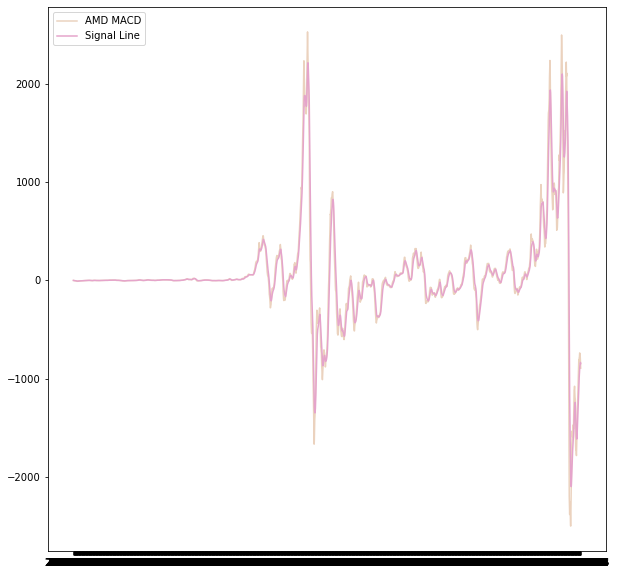

In [25]:
data_index['madc_index'], data_index['signa_index'] = MACD(data_index)

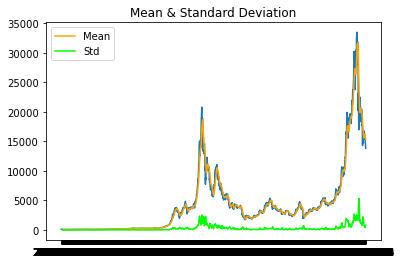

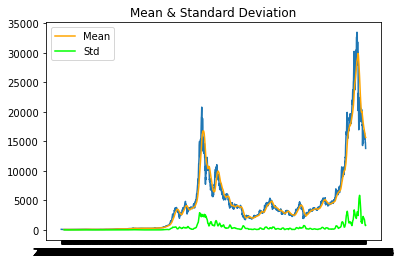

In [26]:
data_index['mediamovil12_id'], data_index['sdmovil12_id'] = rolmean_std(data_index, 12)
data_index['mediamovil24_id'], data_index['sdmovil24_id'] = rolmean_std(data_index, 24)

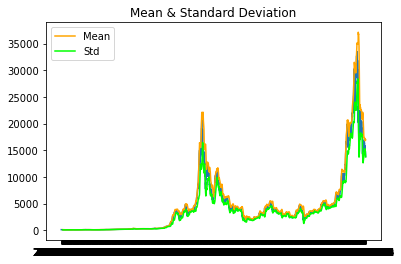

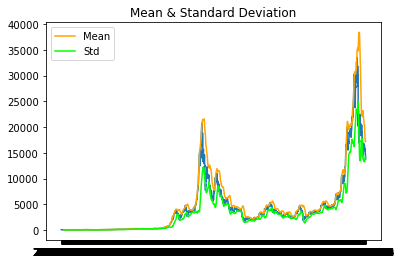

In [27]:
data_index['bollup12_id'] , data_index['bolldw12_id'] = bollinger(data_index,12)
data_index['bollup24_id'] , data_index['bolldw24_id'] = bollinger(data_index,24)

In [28]:
data_index['index_return'] = var_porcentual(data_index, 'Close')

In [29]:
data_index = data_index.rename(columns = {'Close':'Close_idx'})
data_index.columns

Index(['Date', 'Open_idx', 'High_idx', 'Low_idx', 'Close_idx', 'Volume_idx',
       'madc_index', 'signa_index', 'mediamovil12_id', 'sdmovil12_id',
       'mediamovil24_id', 'sdmovil24_id', 'bollup12_id', 'bolldw12_id',
       'bollup24_id', 'bolldw24_id', 'index_return'],
      dtype='object')

### check data

In [30]:
data_index = data_index.set_index(data_index['Date'], drop=False, append=False, inplace=False, verify_integrity=False).drop('Date', 1)

In [31]:
data_index.head()

,Open_idx,High_idx,Low_idx,Close_idx,Volume_idx,madc_index,signa_index,mediamovil12_id,sdmovil12_id,mediamovil24_id,sdmovil24_id,bollup12_id,bolldw12_id,bollup24_id,bolldw24_id,index_return
Date,,,,,,,,,,,,,,,,
2021-07-16,14298.4,14594.6,13685.3,13808.9,5.488243e+10,-893.484659,-846.481058,15355.558333,798.679368,15648.700000,788.625730,16952.917070,13758.199596,17225.951460,14071.448540,-0.032509
2021-07-15,14843.1,15109.5,13993.4,14272.9,5.758054e+10,-829.703902,-834.730158,15591.741667,714.333562,15668.933333,744.357638,17020.408790,14163.074544,17157.648610,14180.218057,-0.037923
2021-07-14,14828.8,15117.9,14065.1,14835.5,5.456745e+10,-783.471679,-835.986722,15759.125000,604.017900,15675.654167,731.827493,16967.160801,14551.089199,17139.309152,14211.999181,0.000951
2021-07-13,15253.9,15394.3,14614.8,14821.4,5.542075e+10,-770.349508,-849.115483,15846.175000,529.479439,15800.279167,830.549044,16905.133879,14787.216121,17461.377254,14139.181079,-0.029232
2021-07-12,15793.4,16084.8,14996.1,15267.7,5.904318e+10,-740.960126,-868.806977,15922.883333,423.613535,15918.979167,886.270063,16770.110403,15075.656263,17691.519292,14146.439041,-0.032913


### Blockchain data

In [32]:
data_hrate = quandl.get("BCHAIN/HRATE", authtoken="RbZN-zdxZx7iLnsP4S9k")
data_hrate.columns = ['hrate']

In [33]:
data_wallet = quandl.get("BCHAIN/MWNUS", authtoken="RbZN-zdxZx7iLnsP4S9k")
data_wallet.columns = ['wallet']

In [34]:
data_volumen = quandl.get("BCHAIN/TRVOU", authtoken="RbZN-zdxZx7iLnsP4S9k")
data_volumen.columns = ['volumen']

In [35]:
data_bsize = quandl.get("BCHAIN/AVBLS", authtoken="RbZN-zdxZx7iLnsP4S9k")
data_bsize.columns = ['bsize']

In [36]:
data_dif = quandl.get("BCHAIN/DIFF", authtoken="RbZN-zdxZx7iLnsP4S9k")
data_dif.columns = ['dif']

## Merge Data

In [37]:
data_full = pd.merge(data, data_index, how='left', on=None, left_on=None, right_on=None, left_index=True, right_index=True, sort=True)
data_full = pd.merge(data_full, data_hrate, how='left', on=None, left_on=None, right_on=None, left_index=True, right_index=True, sort=True)
data_full = pd.merge(data_full, data_wallet, how='left', on=None, left_on=None, right_on=None, left_index=True, right_index=True, sort=True)
data_full = pd.merge(data_full, data_volumen, how='left', on=None, left_on=None, right_on=None, left_index=True, right_index=True, sort=True)
data_full = pd.merge(data_full, data_bsize, how='left', on=None, left_on=None, right_on=None, left_index=True, right_index=True, sort=True)
data_full = pd.merge(data_full, data_dif, how='left', on=None, left_on=None, right_on=None, left_index=True, right_index=True, sort=True)


In [38]:
data_full.sort_index(ascending = False, inplace = True)

In [39]:
data_full.tail()

,Open,High,Low,Close,Volume,Market Cap,macd,signal,mediamovil12,sdmovil12,...,bollup12_id,bolldw12_id,bollup24_id,bolldw24_id,index_return,hrate,wallet,volumen,bsize,dif
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-05,1156.729980,1191.099976,910.416992,902.200989,510199008.0,1.630025e+10,-3.089585,2.462985,NaN,NaN,...,363.722081,265.603086,348.033699,243.130134,-0.100986,2.210933e+06,11093917.0,2.084983e+08,0.984197,3.176884e+11
2017-01-04,1044.400024,1159.420044,1044.400024,1013.380005,344945984.0,1.857187e+10,8.552956,3.851127,NaN,NaN,...,360.520095,260.986405,343.702403,242.057347,0.110206,2.432026e+06,11064485.0,1.431343e+08,0.980000,3.176884e+11
2017-01-03,1021.599976,1044.079956,1021.599976,1154.729980,185168000.0,1.678637e+10,11.968620,2.675670,NaN,NaN,...,336.891451,270.932382,327.793083,249.220333,0.036166,2.589950e+06,11037425.0,8.324526e+06,0.900000,3.176884e+11
2017-01-02,998.617004,1031.390015,996.702026,1043.839966,222184992.0,1.642902e+10,1.762163,0.352433,NaN,NaN,...,328.571405,270.216762,320.619504,250.704913,0.023202,2.526780e+06,11012695.0,5.759703e+07,0.944878,3.176884e+11
2017-01-01,963.658020,1003.080017,958.698975,1021.750000,147775008.0,1.605041e+10,0.000000,0.000000,NaN,NaN,...,322.992225,268.369109,315.086408,251.819592,0.019670,2.463611e+06,10992405.0,3.399191e+07,0.690000,3.176884e+11


In [40]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1657 entries, 2021-07-15 to 2017-01-01
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             1657 non-null   float64
 1   High             1657 non-null   float64
 2   Low              1657 non-null   float64
 3   Close            1657 non-null   float64
 4   Volume           1657 non-null   float64
 5   Market Cap       1657 non-null   float64
 6   macd             1657 non-null   float64
 7   signal           1657 non-null   float64
 8   mediamovil12     1646 non-null   float64
 9   sdmovil12        1646 non-null   float64
 10  mediamovil26     1632 non-null   float64
 11  sdmovil26        1632 non-null   float64
 12  bollup12         1646 non-null   float64
 13  bolldw12         1646 non-null   float64
 14  bollup26         1632 non-null   float64
 15  bolldw26         1632 non-null   float64
 16  btc_return       1656 non-null   float64
 

Missing values has been generated when computing technical indicators.So we'll change NaN by 0. 

In [41]:
data_full = data_full.fillna(0)

# EDA

### BTC price

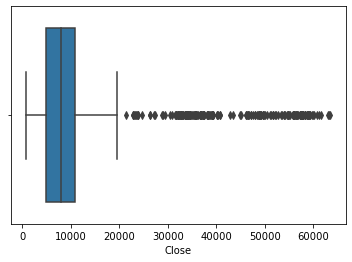

In [42]:
sns.boxplot(data_full['Close'])

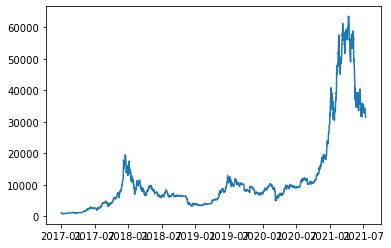

In [43]:
plt.plot(data_full.index, data_full['Close'])

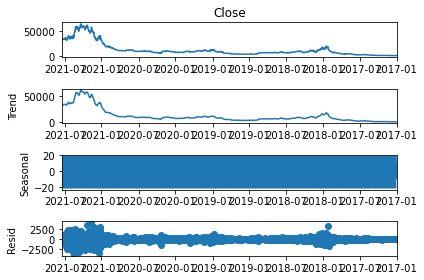

In [44]:
a = seasonal_decompose(data_full['Close'], model = 'add')
a.plot();

In [45]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(data_full['Close'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Results of Dickey-Fuller Test:


Test Statistic                   -1.627318
p-value                           0.468895
#Lags Used                       25.000000
Number of Observations Used    1631.000000
dtype: float64

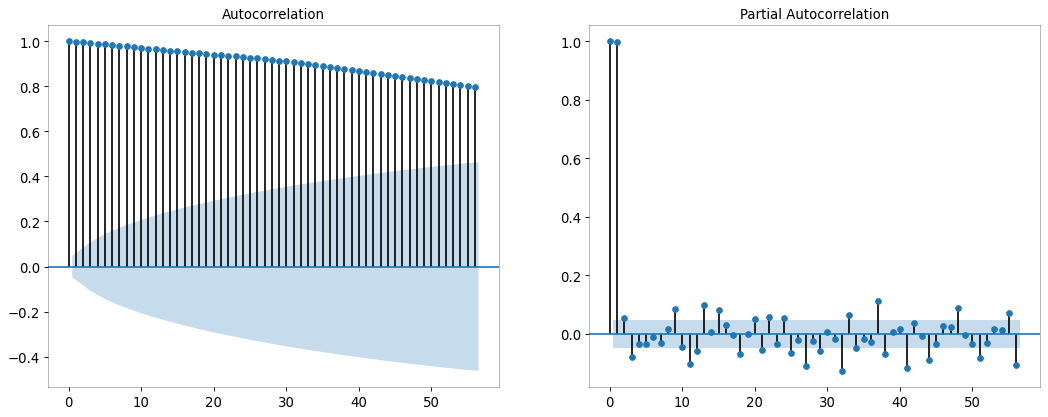

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(data_full.Close.tolist(), ax=ax1, lags=56)
plot_pacf(data_full.Close.tolist(), ax=ax2, lags=56)

ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)

ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

### BTC return

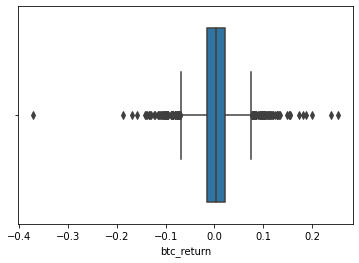

In [47]:
sns.boxplot(data_full['btc_return'])

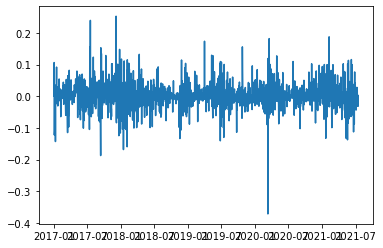

In [48]:
plt.plot(data_full.index, data_full['btc_return'])

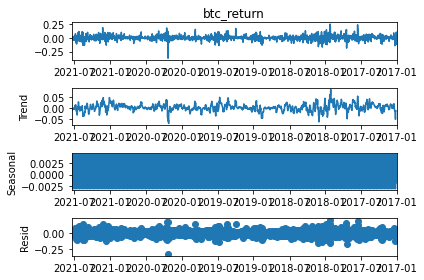

In [49]:
a = seasonal_decompose(data_full['btc_return'], model = 'add')
a.plot();

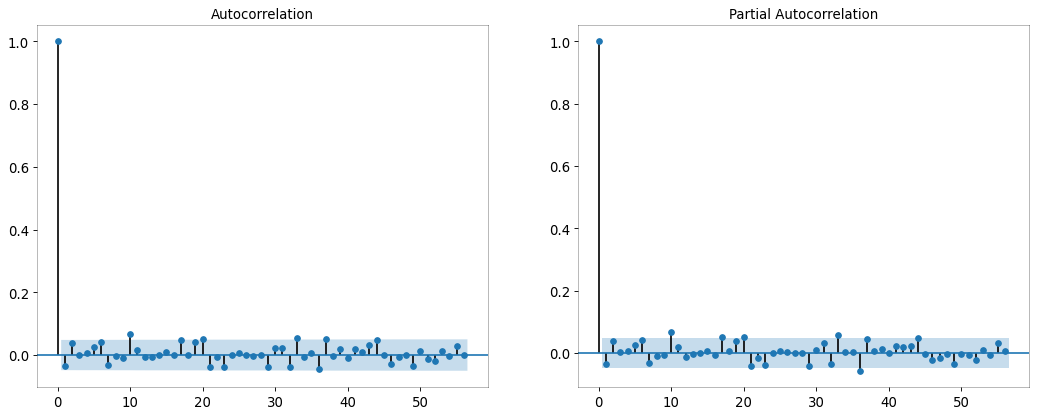

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(data_full.btc_return.tolist(), ax=ax1, lags=56)
plot_pacf(data_full.btc_return.tolist(), ax=ax2, lags=56)

ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)

ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

### other variables

In [51]:
col = list(data_full.columns)

Open


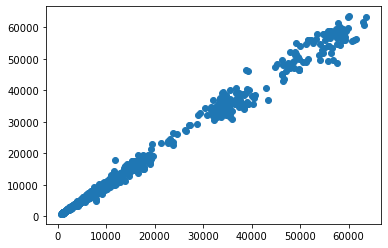

High


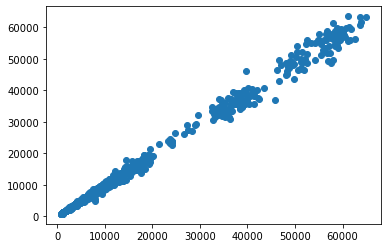

Low


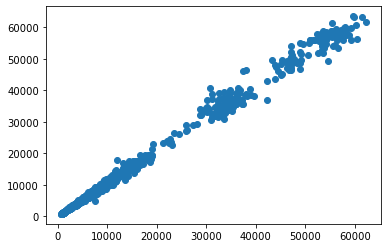

Close


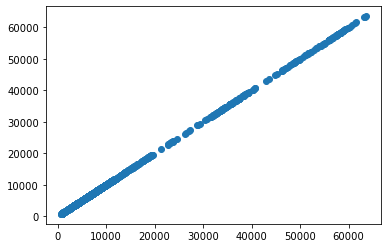

Volume


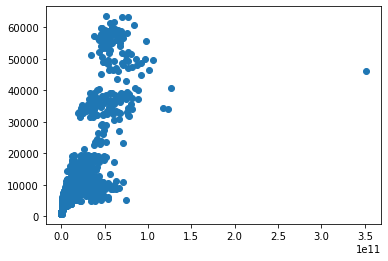

Market Cap


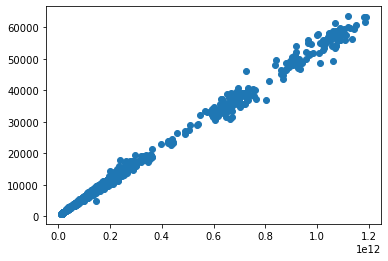

macd


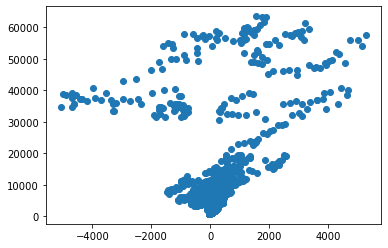

signal


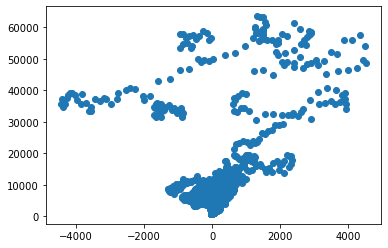

mediamovil12


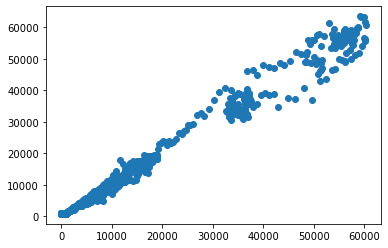

sdmovil12


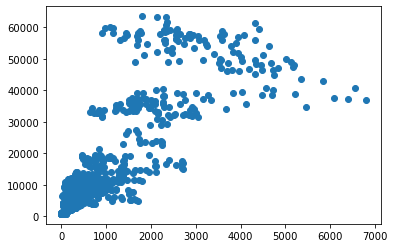

mediamovil26


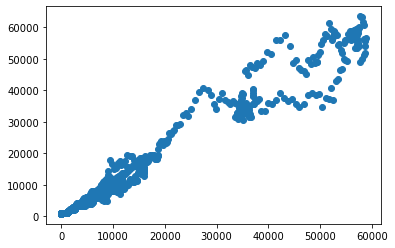

sdmovil26


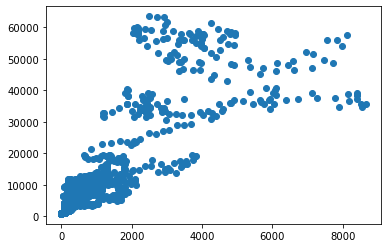

bollup12


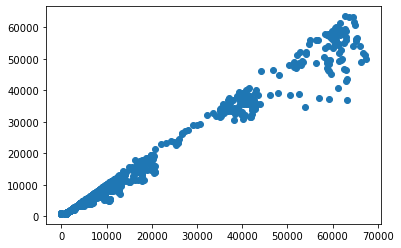

bolldw12


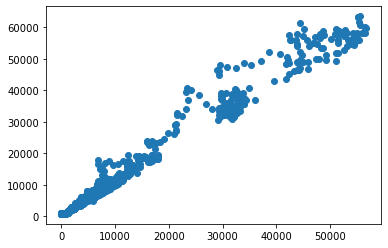

bollup26


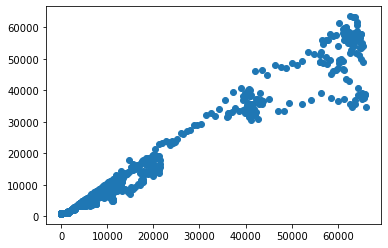

bolldw26


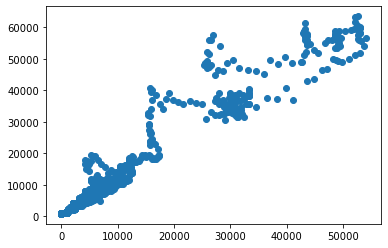

btc_return


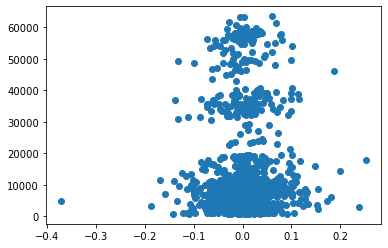

Open_idx


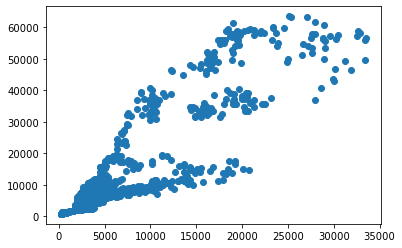

High_idx


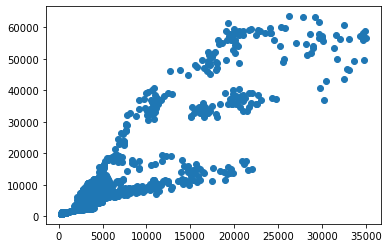

Low_idx


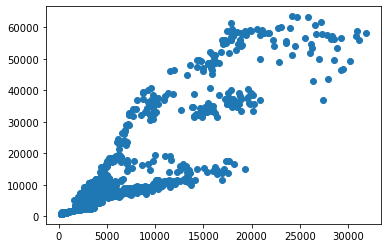

Close_idx


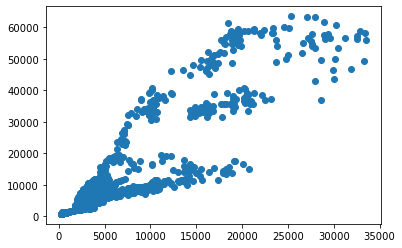

Volume_idx


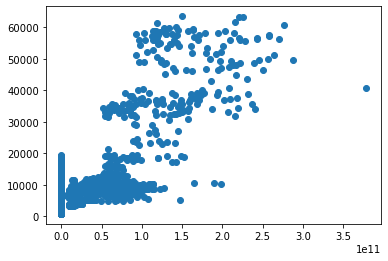

madc_index


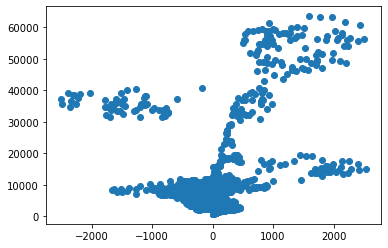

signa_index


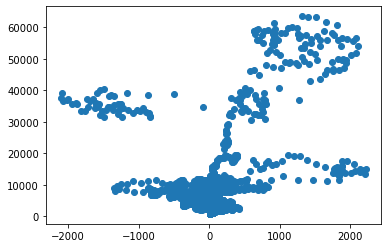

mediamovil12_id


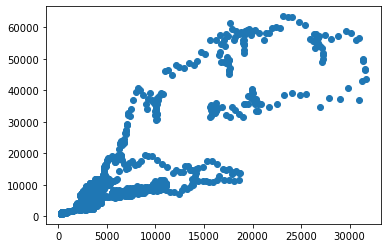

sdmovil12_id


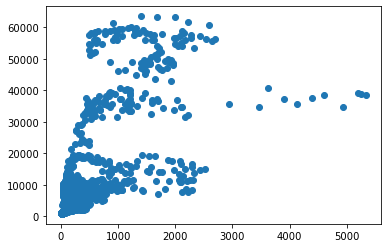

mediamovil24_id


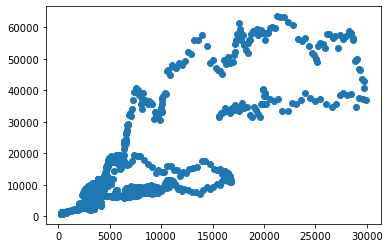

sdmovil24_id


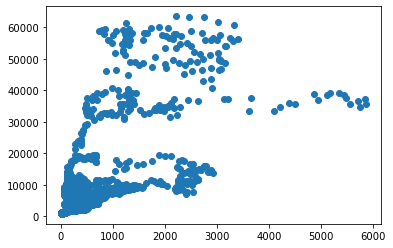

bollup12_id


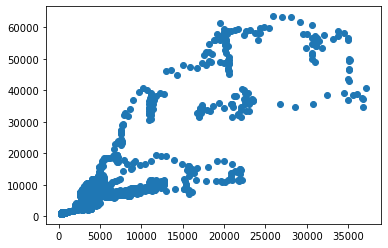

bolldw12_id


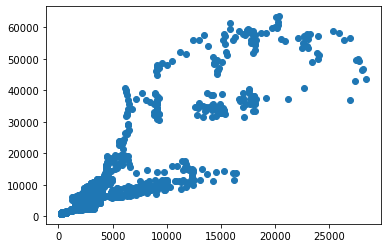

bollup24_id


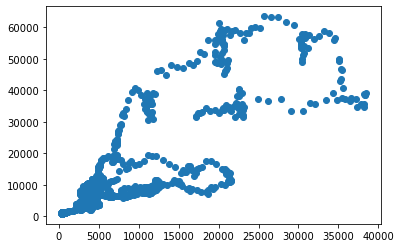

bolldw24_id


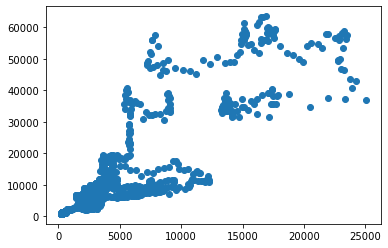

index_return


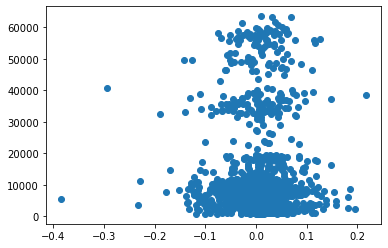

hrate


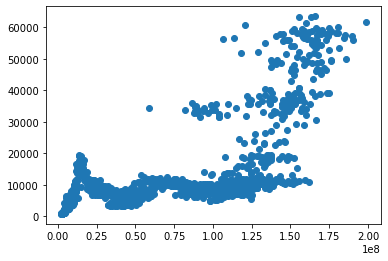

wallet


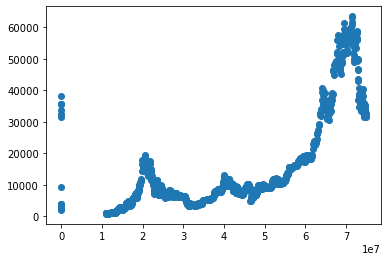

volumen


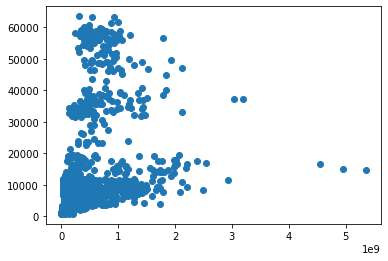

bsize


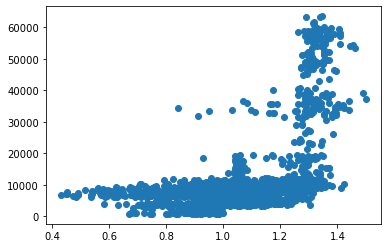

dif


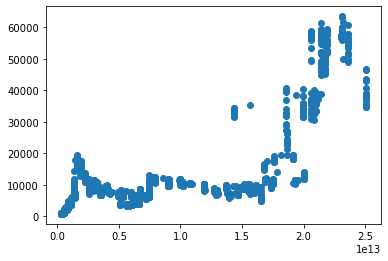

In [52]:
for i in col:
    print(i)
    plt.scatter(data_full[i], data_full['Close'])
    plt.show()

In [53]:
#data_full['dif_var'] = var_porcentual(data_full, 'dif')
#data_full['wallet_var'] = var_porcentual(data_full, 'wallet')

In [54]:
#print('dif_var')
#plt.scatter(data_full['dif_var'], data_full['Close'])
#plt.show()

#print('wallet_var')
#plt.scatter(data_full['wallet_var'], data_full['Close'])
#plt.show()

Open


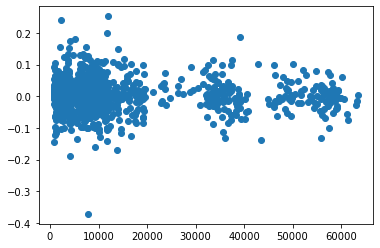

High


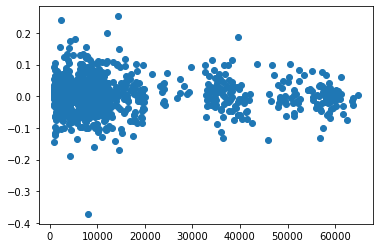

Low


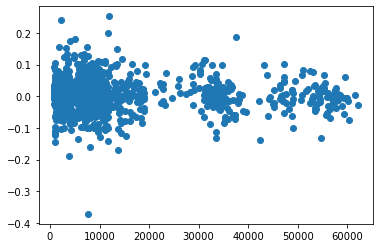

Close


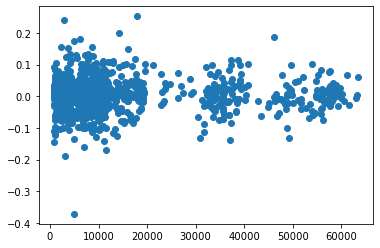

Volume


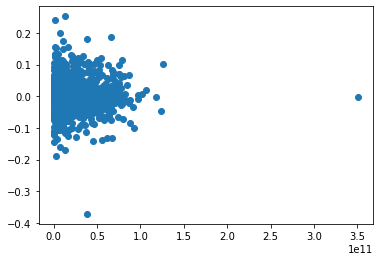

Market Cap


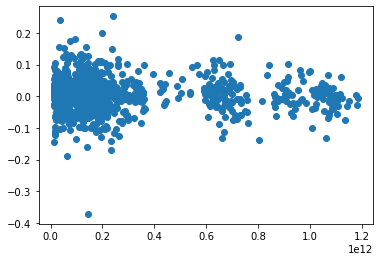

macd


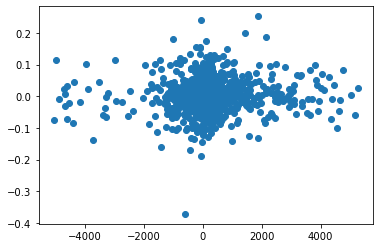

signal


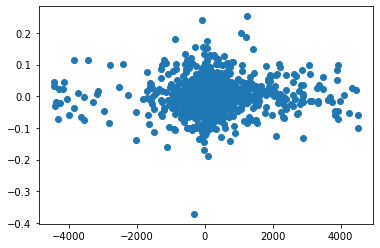

mediamovil12


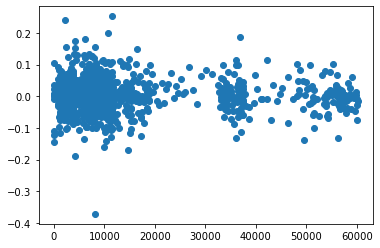

sdmovil12


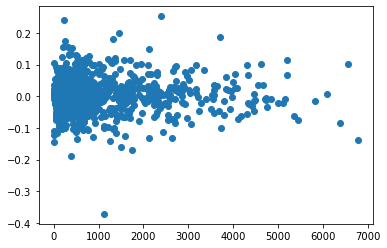

mediamovil26


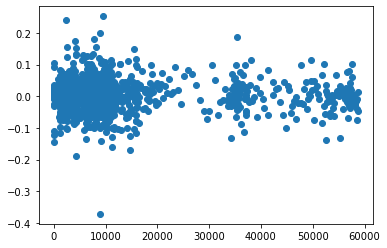

sdmovil26


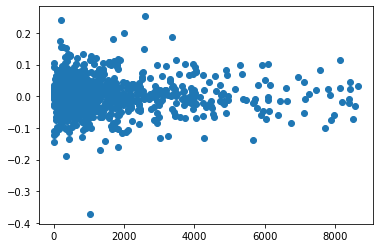

bollup12


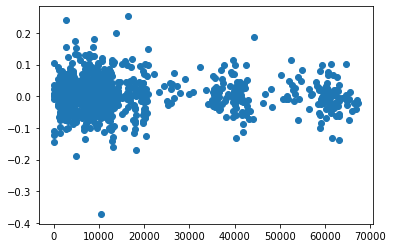

bolldw12


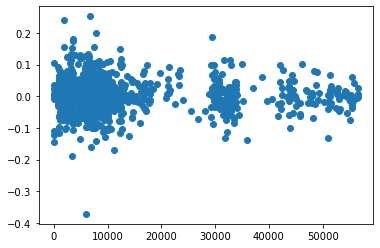

bollup26


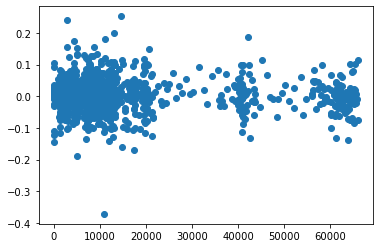

bolldw26


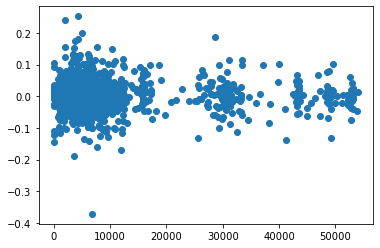

btc_return


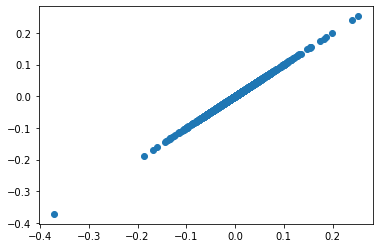

Open_idx


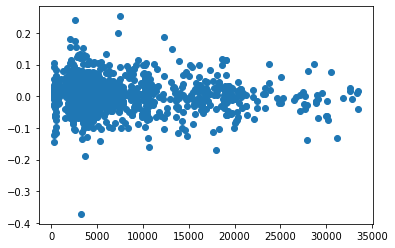

High_idx


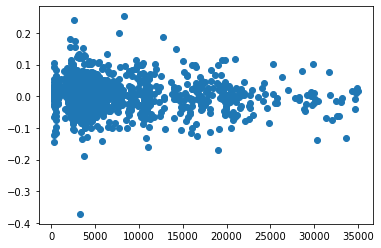

Low_idx


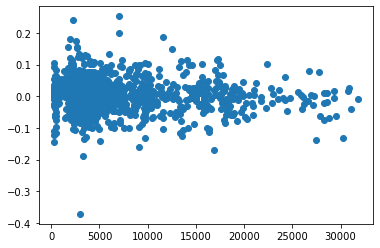

Close_idx


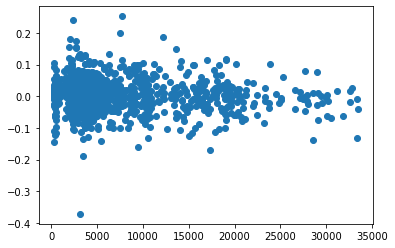

Volume_idx


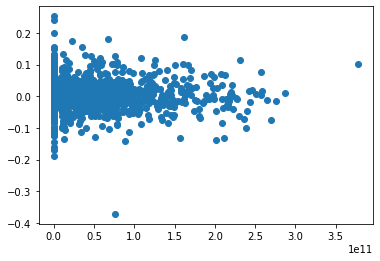

madc_index


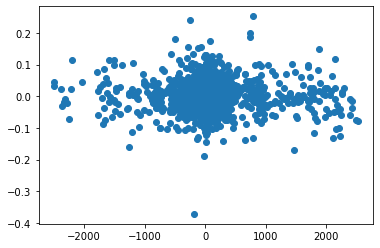

signa_index


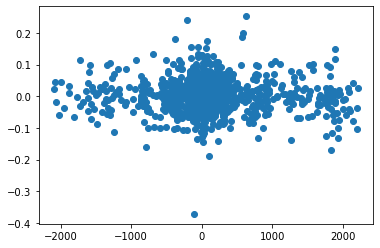

mediamovil12_id


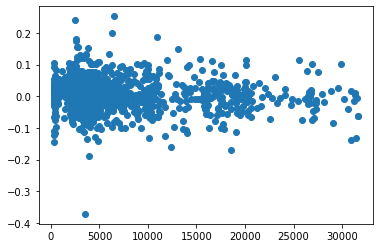

sdmovil12_id


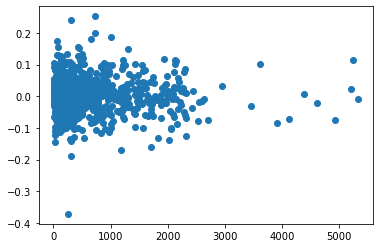

mediamovil24_id


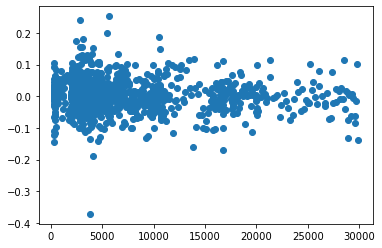

sdmovil24_id


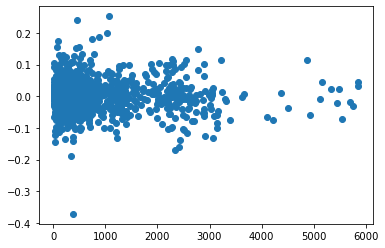

bollup12_id


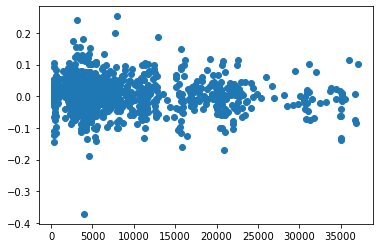

bolldw12_id


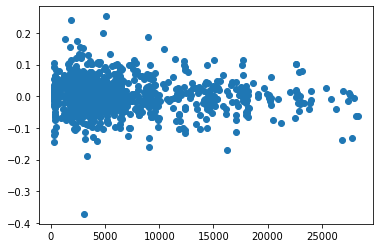

bollup24_id


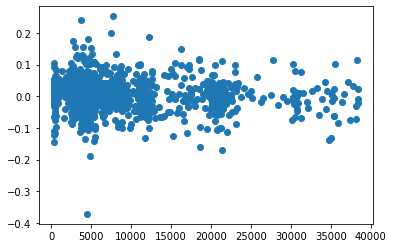

bolldw24_id


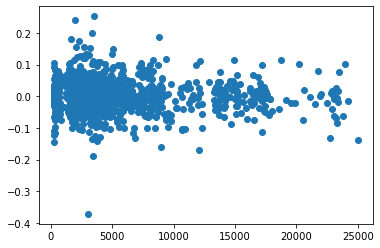

index_return


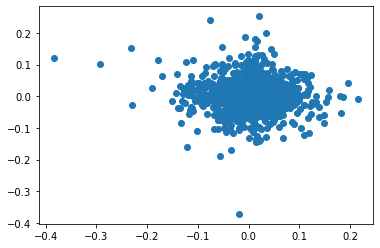

hrate


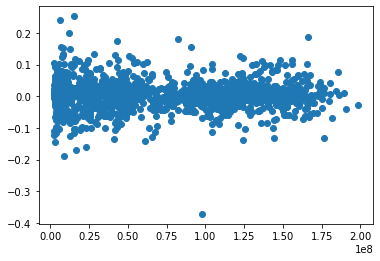

wallet


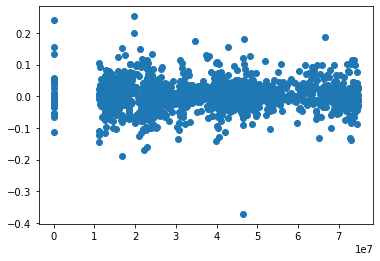

volumen


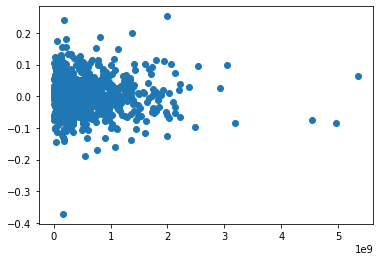

bsize


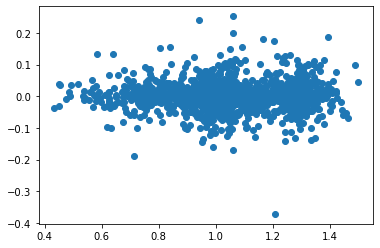

dif


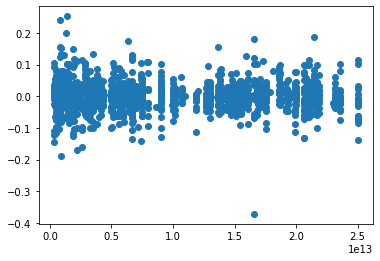

In [55]:
for i in col:
    print(i)
    plt.scatter(data_full[i], data_full['btc_return'])
    plt.show()

In [56]:

lista = []

for i in col :
    coef, p_value = stats.spearmanr(data_full['Close'], data_full[i], nan_policy='omit')
    
    if p_value < 0.05: 
        
        if coef < 0.99:
        
            print(f"Correlación Spearman for {i}: coef={coef}, p-value={p_value}")

            lista = np.append(lista, i)



Correlación Spearman for Volume: coef=0.8185372045398545, p-value=0.0
Correlación Spearman for macd: coef=0.25783517134714007, p-value=1.4296285705012216e-26
Correlación Spearman for signal: coef=0.2647929993553434, p-value=5.510984782205737e-28
Correlación Spearman for mediamovil12: coef=0.9887355443098965, p-value=0.0
Correlación Spearman for sdmovil12: coef=0.7712485993111025, p-value=0.0
Correlación Spearman for mediamovil26: coef=0.9729556616085024, p-value=0.0
Correlación Spearman for sdmovil26: coef=0.7806776163636745, p-value=0.0
Correlación Spearman for bollup12: coef=0.9822552714676033, p-value=0.0
Correlación Spearman for bolldw12: coef=0.9782244855465174, p-value=0.0
Correlación Spearman for bollup26: coef=0.9663374092076897, p-value=0.0
Correlación Spearman for bolldw26: coef=0.9423103875911644, p-value=0.0
Correlación Spearman for Open_idx: coef=0.8044938867140771, p-value=0.0
Correlación Spearman for High_idx: coef=0.7994426503083402, p-value=0.0
Correlación Spearman for

In [57]:

lista1 = []

for i in col :
    coef, p_value = stats.spearmanr(data_full['btc_return'], data_full[i], nan_policy='omit')
    
    if p_value < 0.05: 
        
        if coef < 0.99:
        
            print(f"Correlación Spearman for {i}: coef={coef}, p-value={p_value}")

            lista1 = np.append(lista1, i)

  

Correlación Spearman for Open: coef=-0.05416627676450178, p-value=0.027463805737119207
Correlación Spearman for High: coef=-0.054109765541000235, p-value=0.02762592125536418
Correlación Spearman for Low: coef=-0.057237730961856616, p-value=0.019801588375186023
Correlación Spearman for Market Cap: coef=-0.05869906899856258, p-value=0.01686318053556544
Correlación Spearman for macd: coef=0.10445519378766435, p-value=2.040329369750907e-05
Correlación Spearman for signal: coef=0.06847256574395232, p-value=0.0052963855785792035
Correlación Spearman for mediamovil12: coef=-0.05394607146086907, p-value=0.02810017732971225
Correlación Spearman for mediamovil26: coef=-0.05773448776777131, p-value=0.0187561473240922
Correlación Spearman for bolldw12: coef=-0.061402286016214405, p-value=0.012421764330625583
Correlación Spearman for bollup26: coef=-0.052230496176373396, p-value=0.03350699713109303
Correlación Spearman for bolldw26: coef=-0.06834326496059821, p-value=0.005383322424033515
Correlació

In [58]:
lista = np.append(lista, 'Close')
lista

array(['Volume', 'macd', 'signal', 'mediamovil12', 'sdmovil12',
       'mediamovil26', 'sdmovil26', 'bollup12', 'bolldw12', 'bollup26',
       'bolldw26', 'Open_idx', 'High_idx', 'Low_idx', 'Close_idx',
       'Volume_idx', 'madc_index', 'signa_index', 'mediamovil12_id',
       'sdmovil12_id', 'mediamovil24_id', 'sdmovil24_id', 'bollup12_id',
       'bolldw12_id', 'bollup24_id', 'bolldw24_id', 'hrate', 'wallet',
       'volumen', 'bsize', 'dif', 'Close'], dtype='<U32')

In [59]:
lista1 = np.append(lista1, 'Close')
lista1

array(['Open', 'High', 'Low', 'Market Cap', 'macd', 'signal',
       'mediamovil12', 'mediamovil26', 'bolldw12', 'bollup26', 'bolldw26',
       'Low_idx', 'Close_idx', 'mediamovil12_id', 'mediamovil24_id',
       'bollup12_id', 'bolldw12_id', 'bollup24_id', 'bolldw24_id',
       'index_return', 'Close'], dtype='<U32')

# Modelo for Price

### train - test split 

In [110]:
data_price = data_full

In [111]:
col_last = data_price.columns

In [153]:
scaler = MinMaxScaler()
scaler.fit(data_price)
data_price[col_last] = scaler.transform(data_price)


In [186]:
size = int(len(data_full)*0.20)
size

331

In [187]:

x_test_p, x_train_p = data_price[0:size], data_price[size:]
y_train_p = x_train_p['Close']
y_test_p =x_test_p['Close']

x_train_p = x_train_p.drop('Close', axis = 1)
x_test_p = x_test_p.drop('Close', axis = 1)
x_train_p = x_train_p.drop('btc_return', axis = 1)
x_test_p = x_test_p.drop('btc_return', axis = 1)

print('set de entrenamiento: ', x_train_p.shape, '\n variables:',x_train_p.columns)
print('set de prueba: ', x_test_p.shape, '\n variables:',x_test_p.columns)

set de entrenamiento:  (1326, 36) 
 variables: Index(['Open', 'High', 'Low', 'Volume', 'Market Cap', 'macd', 'signal',
       'mediamovil12', 'sdmovil12', 'mediamovil26', 'sdmovil26', 'bollup12',
       'bolldw12', 'bollup26', 'bolldw26', 'Open_idx', 'High_idx', 'Low_idx',
       'Close_idx', 'Volume_idx', 'madc_index', 'signa_index',
       'mediamovil12_id', 'sdmovil12_id', 'mediamovil24_id', 'sdmovil24_id',
       'bollup12_id', 'bolldw12_id', 'bollup24_id', 'bolldw24_id',
       'index_return', 'hrate', 'wallet', 'volumen', 'bsize', 'dif'],
      dtype='object')
set de prueba:  (331, 36) 
 variables: Index(['Open', 'High', 'Low', 'Volume', 'Market Cap', 'macd', 'signal',
       'mediamovil12', 'sdmovil12', 'mediamovil26', 'sdmovil26', 'bollup12',
       'bolldw12', 'bollup26', 'bolldw26', 'Open_idx', 'High_idx', 'Low_idx',
       'Close_idx', 'Volume_idx', 'madc_index', 'signa_index',
       'mediamovil12_id', 'sdmovil12_id', 'mediamovil24_id', 'sdmovil24_id',
       'bollup12_id',

In [188]:
print(x_train_p.index.min(), '|' ,x_train_p.index.max() )

2017-01-01 00:00:00 | 2020-08-18 00:00:00


### XGBoost

In [259]:
nrounds_values = [10, 100]
eta_values = [0.3, 0.99]
gamma_values = [0, 1]
max_depth_values = [6, 20]
min_child_weight_values = [1, 20]
subsample_values = [0.1, 1]
colsample_bytree_values = [0.1, 1]
num_parallel_tree_values = [1, 20]
lambda_values = [0, 1]
alpha_values = [0, 1]
random_state = 1

In [261]:
grid_results2 = pd.DataFrame();
num_iter = 0

for nrounds in nrounds_values:
        for eta in eta_values:
            for gamma in gamma_values:
                for max_depth in max_depth_values:
                    for min_child_weight in min_child_weight_values:
                        for subsample in subsample_values:
                            for colsample_bytree in colsample_bytree_values:
                                for num_parallel_tree in num_parallel_tree_values:
                                    for lamda in lambda_values:
                                        for alpha in alpha_values:
                                            
                                                # Actualizar contador
                                            num_iter += 1; 

                                                # print control iteracion modelo
                                            print('Inicio de iteracion ' + str(num_iter) + 
                                                    '. Parametro nrounds = ' + str(nrounds) + 
                                                    ', parametro eta = '  + str(eta) +
                                                    ', parametro gamma = '  + str(gamma) +
                                                    ', parametro max_depth = '  + str(max_depth) +
                                                    ', parametro min_child_weight = '  + str(min_child_weight) +
                                                    ', parametro subsample = '  + str(subsample) +
                                                    ', parametro colsample_bytree = '  + str(colsample_bytree) +
                                                    ', parametro num_parallel_tree = '  + str(num_parallel_tree) +
                                                    ', parametro lambda = '  + str(lamda) +
                                                    ', parametro alpha = '  + str(alpha) + 
                                                    '\n')
                                            
                                            model = XGBRegressor(random_state = random_state,
                                                                      n_estimators = nrounds,
                                                                      learning_rate = eta, 
                                                                      gamma = gamma,
                                                                      max_depth = max_depth,
                                                                      min_child_weight = min_child_weight ,
                                                                      subsample = subsample,
                                                                      colsample_bytree = colsample_bytree,
                                                                      num_parallel_tree = num_parallel_tree,
                                                                      reg_lambda = lamda,
                                                                      reg_alpha = alpha)
                                            model.fit(x_train_p, y_train_p)
                                                
                                                   # Generar predicciones
                                            pred_train = model.predict(x_train_p)
                                            pred_test = model.predict(x_test_p)
                                                
                                                    # Metricas
                                            rmse_train = np.sqrt(metric(y_train_p,pred_train))
                                            rmse_test = np.sqrt(metric(y_test_p, pred_test))
                                                
                                            print('Fin de iteracion ' + str(num_iter) + 
                                                      '. Parametro nrounds = ' + str(nrounds) + 
                                                      ', parametro eta = ' + str(eta) + 
                                                      ', parametro gamma = '  + str(gamma) +
                                                      ', parametro max_depth = '  + str(max_depth) +
                                                      ', parametro min_child_weight = '  + str(min_child_weight) +
                                                      ', parametro subsample = '  + str(subsample) +
                                                      ', parametro colsample_bytree = '  + str(colsample_bytree) +
                                                      ', parametro num_parallel_tree = '  + str(num_parallel_tree) +
                                                      ', parametro lambda = '  + str(lamda) +
                                                      ', parametro alpha = '  + str(alpha) + 
                                                      '. rmse train = '  + str(rmse_train) + 
                                                      ' -  rmse test = '  + str(rmse_test)  + 
                                                      '\n')
                                            grid_results2 = grid_results2.append(pd.DataFrame(data={'params': [{'nrounds':[nrounds],
                                                                                              'eta':[eta],
                                                                                              'gamma':[gamma],
                                                                                              'max_depth':[max_depth],
                                                                                              'min_child_weight':[min_child_weight],
                                                                                              'subsample':[subsample],
                                                                                              'colsample_bytree':[colsample_bytree],
                                                                                              'num_parallel_tree':[num_parallel_tree],
                                                                                              'lamda':[lamda],
                                                                                              'alpha':[alpha]}],
                                                                                              'rmse_train':[rmse_train],
                                                                                              'rmse_val':[rmse_val]},
                                                                                               columns=['params', 'rmse_train', 'rmse_val']), 
                                                                                   ignore_index=True)
                                                    

Inicio de iteracion 1. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. rmse train = 0.013405672224622796 -  rmse test = 0.3846403665893823

Inicio de iteracion 2. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 2. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0,

Fin de iteracion 15. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. rmse train = 0.014628652981243028 -  rmse test = 0.34719496416433737

Inicio de iteracion 16. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 16. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. rmse train = 0.03307125817805352 -  rmse test = 0.3193392197067023

Inicio de iteracion

Fin de iteracion 29. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.011763195386973443 -  rmse test = 0.3813184018098709

Inicio de iteracion 30. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 30. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.016190624376927455 -  rmse test = 0.3437147191474757

Inicio de iteracion 31. P


Inicio de iteracion 45. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 45. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.01653612017925469 -  rmse test = 0.41692571960499764

Inicio de iteracion 46. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 46. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma


Inicio de iteracion 59. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 59. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. rmse train = 0.013104217994531833 -  rmse test = 0.36849353814842584

Inicio de iteracion 60. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 60. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, pa


Inicio de iteracion 76. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 76. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. rmse train = 0.03373204306029668 -  rmse test = 0.3425923627911966

Inicio de iteracion 77. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 77. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 

Fin de iteracion 89. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. rmse train = 0.01153000704120606 -  rmse test = 0.38537922820159787

Inicio de iteracion 90. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 90. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. rmse train = 0.01619066319024077 -  rmse test = 0.3437145113365963

Inicio de iteracion 91. Pa


Inicio de iteracion 104. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 104. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. rmse train = 0.03547165204274522 -  rmse test = 0.41411137186235175

Inicio de iteracion 105. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 105. Parametro nrounds = 10, parametro eta = 0.3, param

Fin de iteracion 117. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.012549719982969918 -  rmse test = 0.38940342372894576

Inicio de iteracion 118. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 118. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.01714164756797686 -  rmse test = 0.37244337042139763

Inicio de

Fin de iteracion 133. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.055465775254436744 -  rmse test = 0.4854191788918904

Inicio de iteracion 134. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 134. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.057398840061561256 -  rmse test = 0.47934470778939714

Inicio de


Inicio de iteracion 147. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 147. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. rmse train = 0.039038066625929305 -  rmse test = 0.46669282341670043

Inicio de iteracion 148. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 148. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma 

Fin de iteracion 160. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. rmse train = 0.03912209303649213 -  rmse test = 0.46583295196839763

Inicio de iteracion 161. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 161. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. rmse train = 0.05561000149454805 -  rmse test = 0.48484376010566077

Inicio de iter

Fin de iteracion 174. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.057398840061561256 -  rmse test = 0.47934470778939714

Inicio de iteracion 175. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 175. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. rmse train = 0.05554253416147049 -  rmse test = 0.48510880466079676

Inicio de it

Fin de iteracion 189. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.03874394847567969 -  rmse test = 0.46690693674562644

Inicio de iteracion 190. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 190. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.039073640825822493 -  rmse test = 0.4658406538421909

Inicio de iteracion


Inicio de iteracion 204. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 204. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. rmse train = 0.057748833570277686 -  rmse test = 0.47847206459535235

Inicio de iteracion 205. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 205. Parametro nrounds = 10, parametro eta = 0.3, parametro ga


Inicio de iteracion 217. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 217. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. rmse train = 0.03874394007291954 -  rmse test = 0.4669071191770203

Inicio de iteracion 218. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 218. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, 


Inicio de iteracion 232. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 232. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. rmse train = 0.05751823397582477 -  rmse test = 0.47904206306705455

Inicio de iteracion 233. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 233. Parametro nrounds = 10, parametro eta = 0.3, param

Fin de iteracion 245. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.037527649530994446 -  rmse test = 0.4659287440372297

Inicio de iteracion 246. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 246. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.04056708098900541 -  rmse test = 0.4691199580271688

Inicio de i

Fin de iteracion 261. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.004343515906993166 -  rmse test = 0.38158942409945074

Inicio de iteracion 262. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 262. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.024753765143487223 -  rmse test = 0.4609403860104688

Inicio


Inicio de iteracion 275. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 275. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. rmse train = 0.004417252783313387 -  rmse test = 0.37634217452403795

Inicio de iteracion 276. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 276. Parametro nrounds = 10, parametro eta = 0.99, parametro ga

Fin de iteracion 288. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. rmse train = 0.0096293777466868 -  rmse test = 0.4244779421442705

Inicio de iteracion 289. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 289. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. rmse train = 0.016709390092141143 -  rmse test = 0.41023830033190717

Inicio de it

Fin de iteracion 302. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.024988515082818154 -  rmse test = 0.4581254487170735

Inicio de iteracion 303. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 303. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. rmse train = 0.008593136705699235 -  rmse test = 0.41592214207337547

Inicio de

Fin de iteracion 317. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.003883077915664863 -  rmse test = 0.3665816928100812

Inicio de iteracion 318. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 318. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.009548715493506277 -  rmse test = 0.4161892312658141

Inicio de iterac


Inicio de iteracion 331. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 331. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. rmse train = 0.020126253294043654 -  rmse test = 0.40174263847117736

Inicio de iteracion 332. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 332. Parametro nrounds = 10, parametro eta = 0.99, parametro


Inicio de iteracion 346. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 346. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. rmse train = 0.009336495266126028 -  rmse test = 0.42577371360312843

Inicio de iteracion 347. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 347. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma

Fin de iteracion 359. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. rmse train = 0.009302396170970423 -  rmse test = 0.4147278046881267

Inicio de iteracion 360. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 360. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. rmse train = 0.025116680717454393 -  rmse test = 0.4598922091635543

I

Fin de iteracion 373. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.0025358745193986617 -  rmse test = 0.3902199597486589

Inicio de iteracion 374. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 374. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.009376301252943222 -  rmse test = 0.42231032210739633

Inici

Fin de iteracion 389. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.05431889997452035 -  rmse test = 0.49498461198051263

Inicio de iteracion 390. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 390. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.05433893628290685 -  rmse test = 0.49353738742920716

Inicio 

Fin de iteracion 405. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.031329032636189094 -  rmse test = 0.47309645086651625

Inicio de iteracion 406. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 406. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.03429943580101096 -  rmse test = 0.4757650105787522

Inicio de ite

Fin de iteracion 421. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.05431889997452035 -  rmse test = 0.49498461198051263

Inicio de iteracion 422. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 422. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.05433893628290685 -  rmse test = 0.49353738742920716

Inic


Inicio de iteracion 435. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 435. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. rmse train = 0.031830330300530084 -  rmse test = 0.4674566792511259

Inicio de iteracion 436. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 436. Parametro nrounds = 10, parametro eta = 0.99, parametro 

Fin de iteracion 448. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. rmse train = 0.031868651337167986 -  rmse test = 0.46678443605222164

Inicio de iteracion 449. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 449. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. rmse train = 0.05468019130723477 -  rmse test = 0.4895367579724138

Inicio de 

Fin de iteracion 461. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.05431889997452035 -  rmse test = 0.49498461198051263

Inicio de iteracion 462. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 462. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.05433893628290685 -  rmse test = 0.49353738742920716

Inicio de 


Inicio de iteracion 477. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 477. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.03181177106973906 -  rmse test = 0.46756367743951627

Inicio de iteracion 478. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 478. Parametro nrounds = 10, parametro eta = 0.99, parametro gam


Inicio de iteracion 492. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 492. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. rmse train = 0.05432767308123442 -  rmse test = 0.4956307540985593

Inicio de iteracion 493. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 493. Parametro nrounds = 10, parametro eta = 0.99, paramet


Inicio de iteracion 505. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 505. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. rmse train = 0.03181177084661952 -  rmse test = 0.467563653098229

Inicio de iteracion 506. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 506. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma

Fin de iteracion 518. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.016377903189007715 -  rmse test = 0.34213647063427

Inicio de iteracion 519. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 519. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. rmse train = 0.0026170436062792368 -  rmse test = 0.3727354597853412

Inicio d


Inicio de iteracion 532. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 532. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. rmse train = 0.008673520032329766 -  rmse test = 0.35407851548662295

Inicio de iteracion 533. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 533. Parametro nrounds = 100, parametro eta = 0.3, parametro g

Fin de iteracion 547. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. rmse train = 0.008543504972250145 -  rmse test = 0.4100770110320185

Inicio de iteracion 548. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 548. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. rmse train = 0.021596471236502258 -  rmse test = 0.41710422217708537

Inicio

Fin de iteracion 560. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. rmse train = 0.01758969352450465 -  rmse test = 0.4140981414101998

Inicio de iteracion 561. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 561. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. rmse train = 0.002139846762574839 -  rmse test = 0.3914037304558025

Inicio de ite

Fin de iteracion 573. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.001594776452059684 -  rmse test = 0.3891717707149343

Inicio de iteracion 574. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 574. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.006930289800116722 -  rmse test = 0.36237633763688265

Inicio de itera

Fin de iteracion 587. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. rmse train = 0.005032964257236082 -  rmse test = 0.35084020814974404

Inicio de iteracion 588. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 588. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. rmse train = 0.017530745243992344 -  rmse test = 0.3426558810853195

Inicio de it

Fin de iteracion 600. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. rmse train = 0.0066679608924049 -  rmse test = 0.34033294231641936

Inicio de iteracion 601. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 601. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. rmse train = 0.0003030254243256062 -  rmse test = 0.39131756410462254

Inicio de itera

Fin de iteracion 613. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.006588542652498501 -  rmse test = 0.411702622252986

Inicio de iteracion 614. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 614. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.01862753358791615 -  rmse test = 0.4172347084712712

Ini

Fin de iteracion 627. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. rmse train = 0.0013478927673667173 -  rmse test = 0.3937704560794606

Inicio de iteracion 628. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 628. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. rmse train = 0.009776715908505805 -  rmse test = 0.3839914524666312

Inicio de

Fin de iteracion 640. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. rmse train = 0.006900944800789194 -  rmse test = 0.36190746160404236

Inicio de iteracion 641. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 641. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. rmse train = 0.05432048318167708 -  rmse test = 0.4951879614328779

Inicio de i

Fin de iteracion 653. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.05431874274818251 -  rmse test = 0.49495104865718803

Inicio de iteracion 654. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 654. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.05431853105805122 -  rmse test = 0.4946884721431744

Inicio de iter

Fin de iteracion 666. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. rmse train = 0.03713323566931987 -  rmse test = 0.4752041904143972

Inicio de iteracion 667. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 667. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. rmse train = 0.03707724212324156 -  rmse test = 0.4761448092419249

Inicio de iteracion 668.

Fin de iteracion 679. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. rmse train = 0.054318749355792485 -  rmse test = 0.49495259780857864

Inicio de iteracion 680. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 680. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. rmse train = 0.0543185572906237 -  rmse test = 0.4946789607846275

Inici

Fin de iteracion 693. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.035746934001120466 -  rmse test = 0.4752877882707638

Inicio de iteracion 694. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 694. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.03869970537528073 -  rmse test = 0.4785206221165738

Inicio de i

Fin de iteracion 707. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. rmse train = 0.054320535790966004 -  rmse test = 0.4951929659607649

Inicio de iteracion 708. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 708. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. rmse train = 0.054325718400688915 -  rmse test = 0.49553676747716613

Inicio

Fin de iteracion 720. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. rmse train = 0.0543185572906237 -  rmse test = 0.4946789607846275

Inicio de iteracion 721. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 721. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. rmse train = 0.037245821924300995 -  rmse test = 0.476404585026434

Inicio de itera

Fin de iteracion 733. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.03702184205615282 -  rmse test = 0.4762757632871331

Inicio de iteracion 734. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 734. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.037133297791436426 -  rmse test = 0.475204122945182

Inicio de iteracio


Inicio de iteracion 747. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 747. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. rmse train = 0.054320535790966004 -  rmse test = 0.4951929659607649

Inicio de iteracion 748. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 748. Parametro nrounds = 100, parametro eta = 0.3, paramet

Fin de iteracion 760. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. rmse train = 0.03682787282714209 -  rmse test = 0.4741574832070171

Inicio de iteracion 761. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 761. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. rmse train = 0.03702182061453626 -  rmse test = 0.47627585538889083

Inicio de iter

Fin de iteracion 773. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.0006899404706622948 -  rmse test = 0.3880732774812523

Inicio de iteracion 774. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 774. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.021113725346372708 -  rmse test = 0.45024344139531924

In


Inicio de iteracion 787. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 787. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. rmse train = 0.0005526940126893451 -  rmse test = 0.3763965203705203

Inicio de iteracion 788. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 788. Parametro nrounds = 100, parametro eta = 0.99, parametr

Fin de iteracion 800. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. rmse train = 0.0096293777466868 -  rmse test = 0.4244779421442705

Inicio de iteracion 801. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 801. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. rmse train = 0.045816573580719284 -  rmse test = 0.4046706176494362

Inicio de 

Fin de iteracion 813. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.004342502681008182 -  rmse test = 0.41469930617795436

Inicio de iteracion 814. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 814. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.021342970812484006 -  rmse test = 0.4481167737983464

Inicio

Fin de iteracion 827. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. rmse train = 0.0005751824164261006 -  rmse test = 0.3704499026039731

Inicio de iteracion 828. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 828. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. rmse train = 0.009893479902273848 -  rmse test = 0.41634620872641054

Inicio de iter

Fin de iteracion 840. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. rmse train = 0.02127654386367344 -  rmse test = 0.4503895967783773

Inicio de iteracion 841. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 841. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. rmse train = 1870643.7159912363 -  rmse test = 4452648.5126985945

Inicio de 

Fin de iteracion 853. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.00021854579748905266 -  rmse test = 0.4040256591003578

Inicio de iteracion 854. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 854. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.0090179185356856 -  rmse test = 0.4242574057571972

Inicio 

Fin de iteracion 867. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. rmse train = 0.05889313443702004 -  rmse test = 0.470872124809736

Inicio de iteracion 868. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 868. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. rmse train = 0.0226328285195524 -  rmse test = 0.44822300211984084

Inic

Fin de iteracion 880. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. rmse train = 0.021382431547339608 -  rmse test = 0.44825755937945705

Inicio de iteracion 881. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 881. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. rmse train = 0.0005741182861648064 -  rmse test = 0.3653150727476645

Inic

Fin de iteracion 893. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.0005067658381947936 -  rmse test = 0.37564459443620063

Inicio de iteracion 894. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 894. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.009489791426238774 -  rmse test = 0.4161872110463395

Inicio d

Fin de iteracion 907. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. rmse train = 0.054326644323414594 -  rmse test = 0.4939958196724372

Inicio de iteracion 908. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 908. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. rmse train = 0.054361142226112 -  rmse test = 0.4965971291693864

Inicio de iterac

Fin de iteracion 920. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. rmse train = 0.037714493839417 -  rmse test = 0.47933940524799823

Inicio de iteracion 921. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 921. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. rmse train = 0.03181177084661952 -  rmse test = 0.467563653098229

Inicio de iteracion 

Fin de iteracion 933. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.05432144926271655 -  rmse test = 0.4943064924718174

Inicio de iteracion 934. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 934. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.05432082751680941 -  rmse test = 0.4952196633846694

Ini

Fin de iteracion 946. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. rmse train = 0.03186173113038233 -  rmse test = 0.46663842432467406

Inicio de iteracion 947. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 947. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. rmse train = 0.031830330300530084 -  rmse test = 0.4674566792511259

Inicio de 

Fin de iteracion 959. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. rmse train = 0.03181654520130153 -  rmse test = 0.4675838809260131

Inicio de iteracion 960. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 960. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. rmse train = 0.031868651337167986 -  rmse test = 0.46678443605222164

Inicio de ite

Fin de iteracion 973. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.05432144926271655 -  rmse test = 0.4943064924718174

Inicio de iteracion 974. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 974. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.05432082751680941 -  rmse test = 0.4952196633846694

Inicio de

Fin de iteracion 986. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. rmse train = 0.03186173113038233 -  rmse test = 0.46663842432467406

Inicio de iteracion 987. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 987. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. rmse train = 0.03181654242090302 -  rmse test = 0.46758378355876856

Inicio de iterac

Fin de iteracion 999. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. rmse train = 0.05432136030244579 -  rmse test = 0.4943135784439829

Inicio de iteracion 1000. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1000. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. rmse train = 0.05432081738187834 -  rmse test = 0.4952187636722187

Fin de iteracion 1013. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. rmse train = 0.031329032636189094 -  rmse test = 0.47309645086651625

Inicio de iteracion 1014. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 1014. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. rmse train = 0.03429943580101096 -  rmse test = 0.4757650105787522

I

In [262]:
print(grid_results2['params'][grid_results2['rmse_test'].idxmin()],grid_results2['rmse_test'][grid_results2['rmse_test'].idxmin()])

{'nrounds': [10], 'eta': [0.3], 'gamma': [0], 'max_depth': [6], 'min_child_weight': [1], 'subsample': [0.1], 'colsample_bytree': [0.1], 'num_parallel_tree': [1], 'lamda': [0], 'alpha': [0]} 0.478431045252118


In [263]:
model = XGBRegressor(random_state = random_state ,n_estimators = 10,learning_rate = 0.3, gamma = 0, max_depth = 6,
                                                                      min_child_weight = 1 ,subsample = 0.1,
                                                                      colsample_bytree = 0.1,num_parallel_tree = 1,
                                                                      reg_lambda = 0, reg_alpha = 0)
model.fit(x_train_p, y_train_p)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=12, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=0.1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [264]:
train_prediction_p = model.predict(x_train_p)
prediction_p = model.predict(x_test_p)

In [265]:
rmse_t = np.sqrt(metric(y_train_p, train_prediction_p))
print('RMSE for test',rmse_t)
rmse = np.sqrt(metric(y_test_p, prediction_p))
print('RMSE for test',rmse)

RMSE for test 0.013405672224622796
RMSE for test 0.3846403665893823


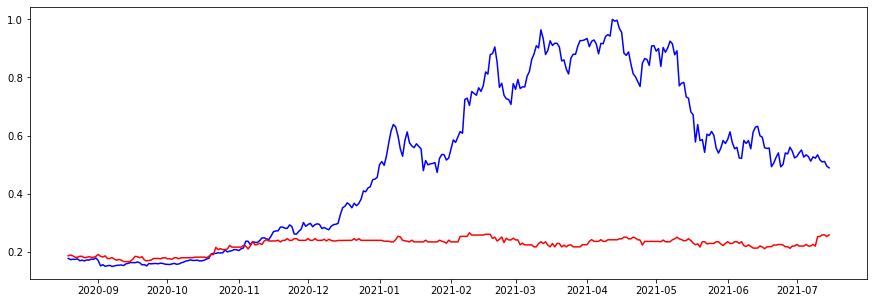

In [266]:
plt.figure(figsize=[15,5])
plt.plot(y_test_p.index, y_test_p, color = 'blue')
plt.plot(y_test_p.index, prediction_p, color = 'red')

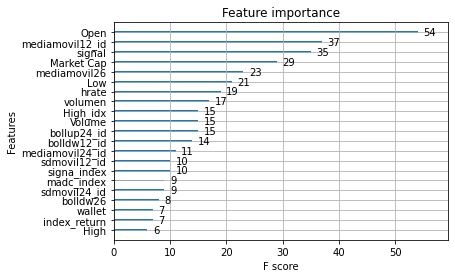

In [267]:
plot_importance(model)

In [268]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test_p)

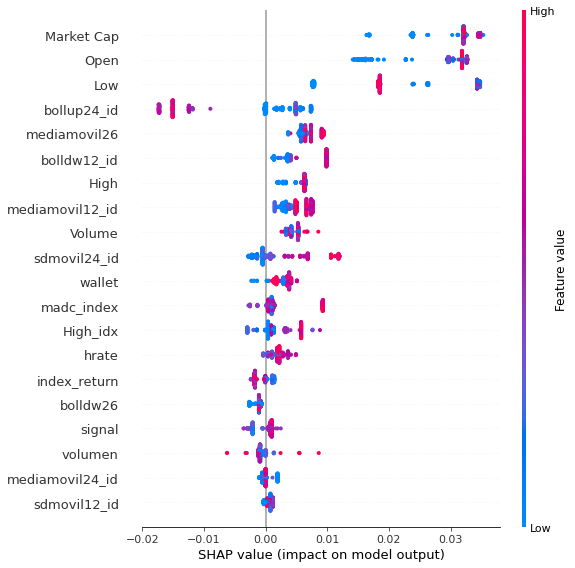

In [269]:
shap.summary_plot(shap_values, x_test_p)


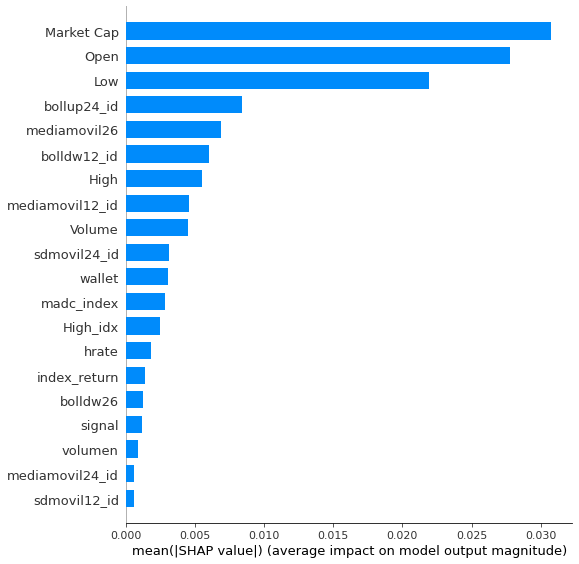

In [270]:
shap.summary_plot(shap_values, x_test_p, plot_type="bar")

### SVR

In [224]:
n = x_train_p.shape[0];
d = x_train_p.shape[1];
m = np.mean(y_train_p);
s = np.std(y_train_p);
C_cherk = np.max([np.abs(m + 3*s),np.abs(m - 3*s)])
c = [C_cherk,10,1,0.1,0.001]
gamma_cherk = np.power(0.2, 1/d)     
gamma= [gamma_cherk, 10, 1, 0.1,0.01]
e = list([10, 1, 0.1,0.01])

[10, 1, 0.1, 0.01]

In [240]:
grid_results1 = pd.DataFrame()

for i in c:
    for z in gamma:
        for j in e:
            model = svm.SVR(gamma=z, C=i, epsilon= j ).fit(x_train_p, y_train_p)
            pred_train = model.predict(x_train_p)
            rmse_train = np.sqrt(metric(y_train_p,pred_train))
            pred_val = model.predict(x_test_p)
            rmse_val = np.sqrt(metric(y_test_p, pred_val))
            grid_results1 = grid_results1.append(pd.DataFrame(data={'params': [{'C':[i],
                                                                                  'gamma_kernel':[z], 'epsilon': [j]}],
                                                                          'rmse_train':[rmse_train],
                                                                          'rmse_val':[rmse_val]},
                                                                   columns=['model','params', 'rmse_train', 'rmse_val']), 
                                                       ignore_index=True)
            print('params:','c: {} '.format(c),'gamma_kernel: {} '.format(z), 'epsilon: {} '.format(j),'rmse_train: {} '.format(rmse_train), 'rmse_val: {}'.format(rmse_val))

params: c: [0.258577067174972, 10, 1, 0.1, 0.001]  gamma_kernel: 0.9562780043468537  epsilon: 10  rmse_train: 0.07630900553498136  rmse_val: 0.45080804751027137
params: c: [0.258577067174972, 10, 1, 0.1, 0.001]  gamma_kernel: 0.9562780043468537  epsilon: 1  rmse_train: 0.07630900553498136  rmse_val: 0.45080804751027137
params: c: [0.258577067174972, 10, 1, 0.1, 0.001]  gamma_kernel: 0.9562780043468537  epsilon: 0.1  rmse_train: 0.05201850304959551  rmse_val: 0.45076176762893067
params: c: [0.258577067174972, 10, 1, 0.1, 0.001]  gamma_kernel: 0.9562780043468537  epsilon: 0.01  rmse_train: 0.006012140181328761  rmse_val: 0.45564275344184907
params: c: [0.258577067174972, 10, 1, 0.1, 0.001]  gamma_kernel: 10  epsilon: 10  rmse_train: 0.07630900553498136  rmse_val: 0.45080804751027137
params: c: [0.258577067174972, 10, 1, 0.1, 0.001]  gamma_kernel: 10  epsilon: 1  rmse_train: 0.07630900553498136  rmse_val: 0.45080804751027137
params: c: [0.258577067174972, 10, 1, 0.1, 0.001]  gamma_kernel:

params: c: [0.258577067174972, 10, 1, 0.1, 0.001]  gamma_kernel: 0.01  epsilon: 0.01  rmse_train: 0.007801893041007758  rmse_val: 0.1202513916263002
params: c: [0.258577067174972, 10, 1, 0.1, 0.001]  gamma_kernel: 0.9562780043468537  epsilon: 10  rmse_train: 0.07630900553498136  rmse_val: 0.45080804751027137
params: c: [0.258577067174972, 10, 1, 0.1, 0.001]  gamma_kernel: 0.9562780043468537  epsilon: 1  rmse_train: 0.07630900553498136  rmse_val: 0.45080804751027137
params: c: [0.258577067174972, 10, 1, 0.1, 0.001]  gamma_kernel: 0.9562780043468537  epsilon: 0.1  rmse_train: 0.05201850304959551  rmse_val: 0.45076176762893067
params: c: [0.258577067174972, 10, 1, 0.1, 0.001]  gamma_kernel: 0.9562780043468537  epsilon: 0.01  rmse_train: 0.006430257676479521  rmse_val: 0.45516394467074905
params: c: [0.258577067174972, 10, 1, 0.1, 0.001]  gamma_kernel: 10  epsilon: 10  rmse_train: 0.07630900553498136  rmse_val: 0.45080804751027137
params: c: [0.258577067174972, 10, 1, 0.1, 0.001]  gamma_ke

In [241]:
print(grid_results1['params'][grid_results1['rmse_val'].idxmin()],grid_results1['rmse_val'][grid_results1['rmse_val'].idxmin()])

{'C': [10], 'gamma_kernel': [0.01], 'epsilon': [0.01]} 0.09865952713806178


In [242]:
model_svr = svm.SVR(gamma= 0.01, C=10, epsilon= 0.01 ).fit(x_train_p, y_train_p)

In [244]:
train_prediction_p_svr = model_svr.predict(x_train_p)
prediction_p_svr = model_svr.predict(x_test_p)

In [245]:
rmse_t = np.sqrt(metric(y_train_p, train_prediction_p_svr))
print('RMSE for train',rmse_t)
rmse = np.sqrt(metric(y_test_p, prediction_p_svr))
print('RMSE for test',rmse)

RMSE for train 0.006254212461775355
RMSE for test 0.09865952713806178


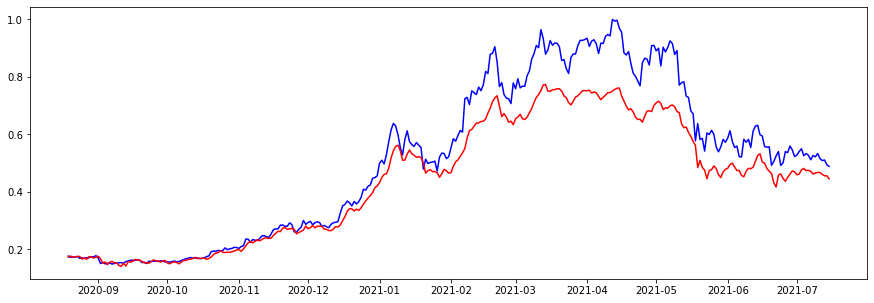

In [246]:
plt.figure(figsize=[15,5])
plt.plot(y_test_p.index, y_test_p, color = 'blue')
plt.plot(y_test_p.index,  prediction_p_svr, color = 'red')

### Auto Arimax

In [250]:
model_ar = auto_arima(y_train_p, exogenous=x_train_p, trace=True, error_action="ignore", suppress_warnings=True)
model_ar.fit(y_train_p, x_train_p)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-11776.146, Time=9.71 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-11074.480, Time=1.22 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-11569.462, Time=6.35 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-11311.847, Time=9.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-11076.479, Time=5.84 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-11770.672, Time=9.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-11770.799, Time=8.72 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-11620.396, Time=9.40 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-11784.205, Time=9.84 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-11765.057, Time=9.52 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-11803.020, Time=10.34 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=-11705.452, Time=10.80 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=-11787.676, Time=12.34 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-11812.860, Time=10.48 sec
 

ARIMA(order=(4, 0, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [251]:
forecast_p = model_ar.predict(n_periods=len(x_test_p), exogenous=x_test_p)

No supported index is available. Prediction results will be given with an integer index beginning at `start`.


In [252]:
rmse = np.sqrt(metric(y_test_p, forecast_p))
print('RMSE for test',rmse)

RMSE for test 0.03244483561869103


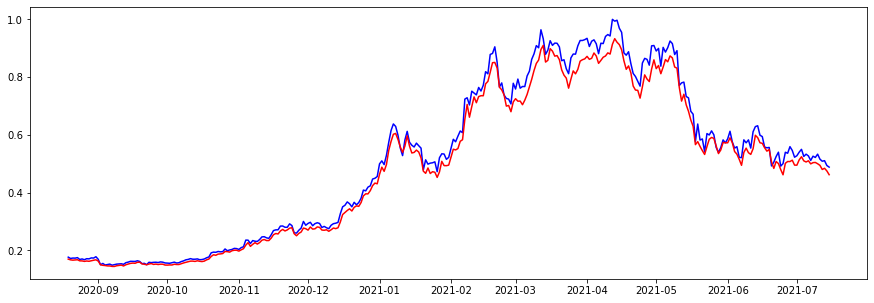

In [253]:
plt.figure(figsize=[15,5])
plt.plot(y_test_p.index, y_test_p, color = 'blue')
plt.plot(y_test_p.index, forecast_p, color = 'red')